In [90]:
import sys
import os
import torch
import numpy as np
import shutil

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image
from PIL import ImageFile
from torchvision.datasets import ImageFolder

sys.path.insert(0, '..')
from data import crop_upper_part
from model import SqueezeModelSoftmax

from sklearn.metrics import classification_report
import pickle

import matplotlib.pyplot as plt

%matplotlib inline

import pdb

In [77]:
# path to a PyTorch state dict
MODEL_PATH = '../models/Standard-No-Test/26-no-test_epoch_10-valLoss_0.02410-valF1_0.99846' 
NUM_CLASSES = 26
INPUT_SHAPE = (3, 370, 400) # C x H x W
BATCH_SIZE = 64

# path to a non-annotated dataset where all images are in same folder with name: <integer_id>.jpg
DATASET_PATH = '../../data/dataset/validation'

NUM_THREADS = 4 # number of threads to use - should be same as number of virtual CPU cores
USE_GPU = True # use CUDA related stuff

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [78]:
class_labels = {
 'Albertsons': 0,
 'BJs': 1,
 'CVSPharmacy': 2,
 'Costco': 3,
 'FredMeyer': 4,
 'Frys': 5,
 'HEB': 6,
 'HarrisTeeter': 7,
 'HyVee': 8,
 'JewelOsco': 9,
 'KingSoopers': 10,
 'Kroger': 11,
 'Meijer': 12,
 'Other': 13,
 'Publix': 14,
 'Safeway': 15,
 'SamsClub': 16,
 'ShopRite': 17,
 'Smiths': 18,
 'StopShop': 19,
 'Target': 20,
 'Walgreens': 21,
 'Walmart': 22,
 'Wegmans': 23,
 'WholeFoodsMarket': 24,
 'WinCoFoods': 25}

class_dict = {v: k for k, v in class_labels.items()}

In [6]:
def data_preprocess_transformations(input_shape, crop_perc = 0.5):
    """Preprocess object for transforming image to model input
    Args:
        input_shape: model input shape (channels x height x width)
        crop_perc: percent of how much image would be cropped from

    Returns:
        Composite of transforms objects.
    """
    
    num_channels, height, width = input_shape
    
    return transforms.Compose([
        transforms.Lambda(lambda x: crop_upper_part(np.array(x), crop_perc)),
        transforms.ToPILImage(),
        transforms.Grayscale(num_channels),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

In [79]:
val_transform = data_preprocess_transformations(INPUT_SHAPE, crop_perc=0.5)
validation_dataset = ImageFolder(root=DATASET_PATH,                                                  
                                      transform=val_transform)                                                                           
    
validation_dataset_loader = DataLoader(validation_dataset,                                                                          
                                            batch_size=BATCH_SIZE,                                                                  
                                            shuffle=False,                                                                               
                                            num_workers=NUM_THREADS)                                                             
                                

In [80]:
# Load model
model = SqueezeModelSoftmax(num_classes=NUM_CLASSES)
model_state_dict = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
model.load_state_dict(model_state_dict)
model.eval()
torch.set_num_threads(NUM_THREADS)

if USE_GPU:
    model.cuda(0)

In [81]:
def var(tensor):
    if USE_GPU:
        tensor = tensor.cuda(0)
    return tensor

# Run prediction
predictions, gts = [], []
num_batches = len(validation_dataset_loader)

for batch_index, (test_batch, ground_truth) in enumerate(validation_dataset_loader):
    batch_input_tensors = var(test_batch)

    batch_predictions = model(batch_input_tensors).cpu().data.numpy()
    predictions.extend(batch_predictions)
    gts.extend(ground_truth.cpu().data.numpy())
    
    print('Batch {}/{}'.format(batch_index + 1, num_batches), end="\r", flush=True)

predictions = np.array(predictions)

In [82]:
print(classification_report(gts, np.argmax(predictions, 1)))

             precision    recall  f1-score   support

          0       1.00      0.99      1.00       334
          1       1.00      1.00      1.00       309
          2       1.00      1.00      1.00       401
          3       1.00      1.00      1.00       371
          4       1.00      1.00      1.00       383
          5       1.00      1.00      1.00       356
          6       1.00      1.00      1.00       383
          7       1.00      1.00      1.00       312
          8       0.99      1.00      1.00       294
          9       1.00      1.00      1.00       405
         10       1.00      0.99      1.00       327
         11       1.00      1.00      1.00       310
         12       1.00      1.00      1.00       382
         13       1.00      1.00      1.00      8909
         14       1.00      0.99      0.99       394
         15       1.00      1.00      1.00       369
         16       1.00      0.99      1.00       329
         17       1.00      1.00      1.00   

In [83]:
# Extract per class max activations
act_dict = {key: [] for key in class_labels.keys()}

for act, gt in zip(predictions, gts):
    pred = np.argmax(act)
    if pred == gt:
        act_dict[class_dict[pred]].append(np.max(act)) 

In [105]:
THR_FILE = "../models/thresholds_2std.pkl"
thr_dict = dict()
for k, act in act_dict.items():
    print("{}: Mean {:.5f}, std {:.5f}".format(k, np.mean(act), np.std(act)))
    thr_dict[k] = 1 - 22.5 * np.std(act)

with open(THR_FILE, "wb") as f:
    pickle.dump(thr_dict, f)

Albertsons: Mean 0.99406, std 0.01157
Walgreens: Mean 0.98524, std 0.01883
Wegmans: Mean 0.99821, std 0.00976
HyVee: Mean 0.99934, std 0.00288
JewelOsco: Mean 0.98069, std 0.04719
Smiths: Mean 0.99485, std 0.00693
FredMeyer: Mean 0.99119, std 0.02283
Other: Mean 0.99462, std 0.03435
CVSPharmacy: Mean 0.99343, std 0.03328
Safeway: Mean 0.99688, std 0.01190
Walmart: Mean 0.99532, std 0.01366
BJs: Mean 0.99429, std 0.02793
WholeFoodsMarket: Mean 0.99584, std 0.00988
Frys: Mean 0.99382, std 0.01485
ShopRite: Mean 0.99473, std 0.02217
HEB: Mean 0.99661, std 0.00845
SamsClub: Mean 0.99459, std 0.02284
Kroger: Mean 0.99674, std 0.00451
KingSoopers: Mean 0.98656, std 0.02184
Meijer: Mean 0.99675, std 0.00321
Publix: Mean 0.99095, std 0.04473
Target: Mean 0.99361, std 0.01409
StopShop: Mean 0.98934, std 0.03472
WinCoFoods: Mean 0.99531, std 0.00980
HarrisTeeter: Mean 0.99590, std 0.01246
Costco: Mean 0.99633, std 0.00874


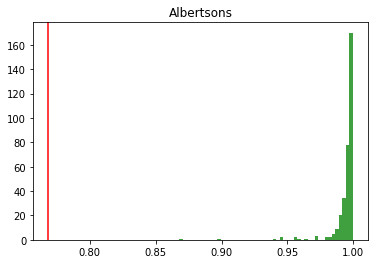

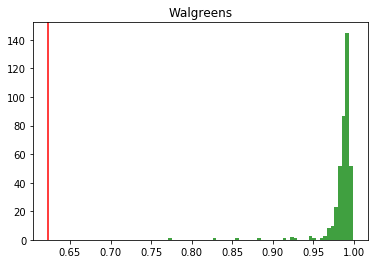

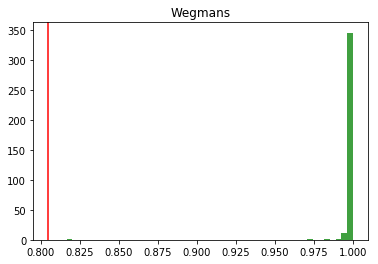

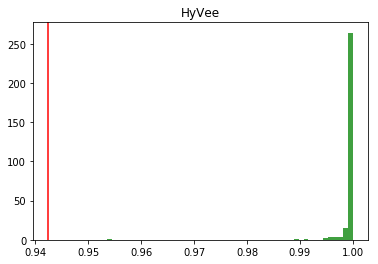

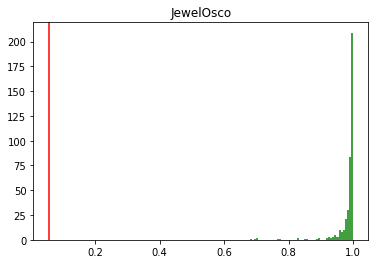

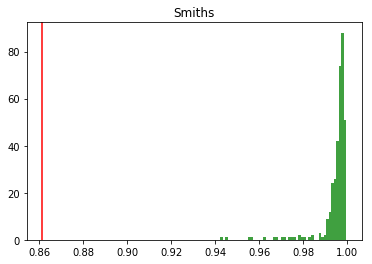

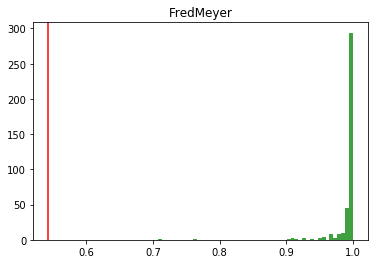

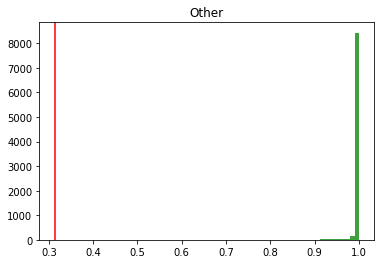

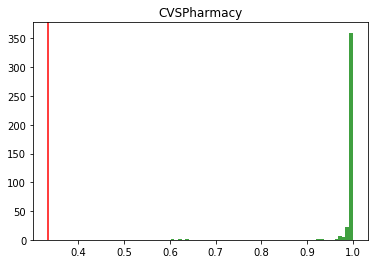

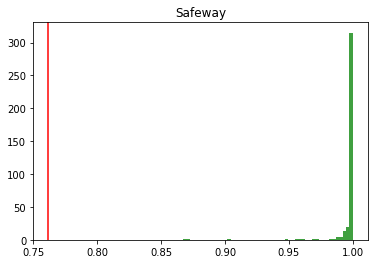

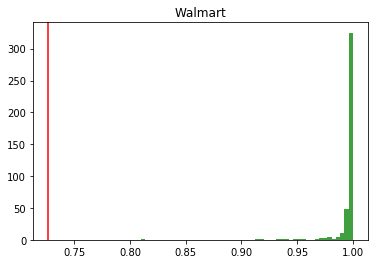

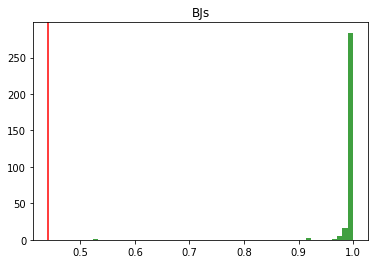

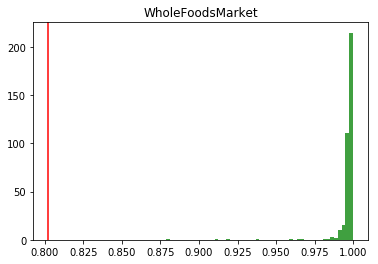

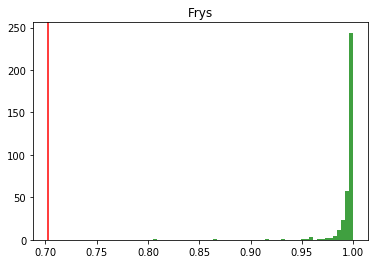

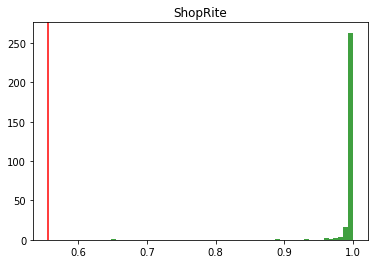

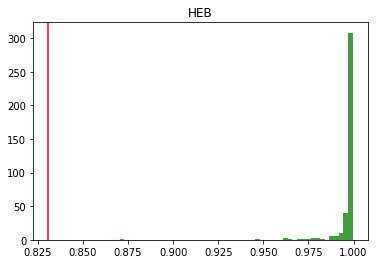

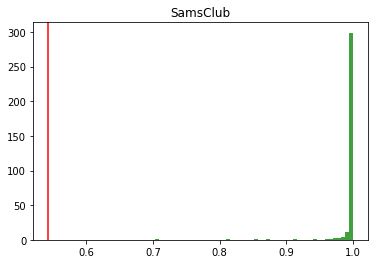

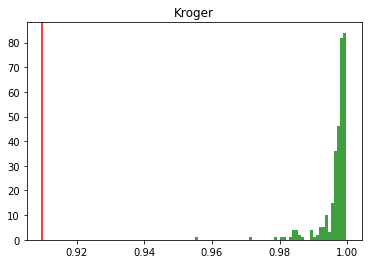

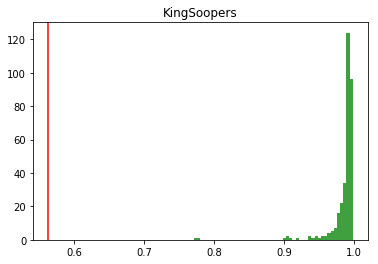

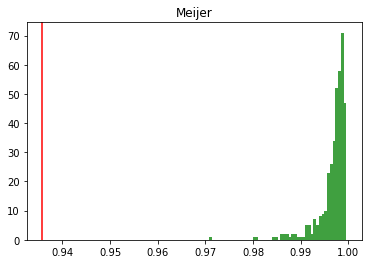

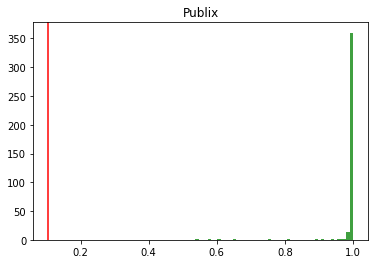

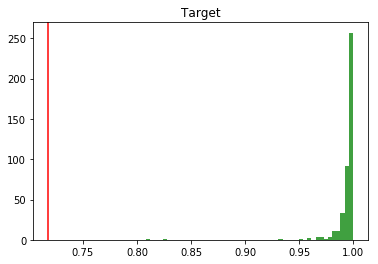

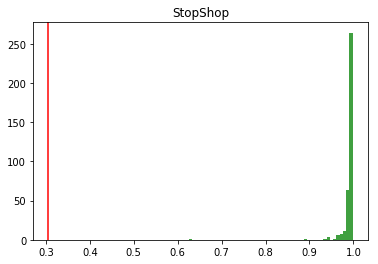

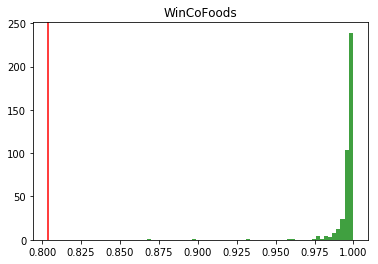

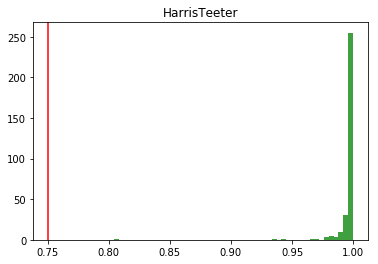

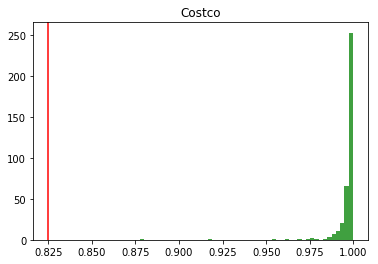

In [102]:
### Plot activation histogram

for k, v in act_dict.items():
    x = list(filter(lambda x: x > 0.5, v))

    plt.hist(x, 50, facecolor='green', alpha=0.75)
    plt.axvline(thr_dict[k], color="red")
    plt.title(k)
    plt.show()